In [1]:
import numpy as np
from pylab import *
from craco.cardcap import CardcapFile
from astropy.io import fits
from craft.craftcor import MiriadGainSolutions
import glob
from craco.search_pipeline import location2pix, get_grid_lut_from_plan, grid_candidates,wait_for_starts,waitall,print_candidates
from craco.search_pipeline import NBINARY_POINT_FDMTIN 
import craco
import craco.search_pipeline
from craco.pyxrtutil import *
import craft.craco_plan

from craft import uvfits

from craft.craco_plan import PipelinePlan
from craft.craco import printstats,bl2ant
import logging
import time
import scipy
import h5py

%matplotlib notebook
%load_ext autoreload
%autoreload 2

Copy from pawsey with $ rsync -avz -e 'ssh -A -J venice.atnf.csiro.au' galaxy.pawsey.org.au:/group/askap/elenc/crap.tgz SB43768_summary.tgz  --progress

In [2]:
cd /data/craco/ban115/craco-python/notebooks/data/SB43768/group/askaprt/mos078/vamplots-askap/results/

/data/craco/ban115/craco-python/notebooks/data/SB43768/group/askaprt/mos078/vamplots-askap/results


In [4]:
ls -lh

total 14G
-rw-rw---- 1 ban115 ban115   644 Sep  7 13:10 2022-09-07_024646_1040MHz.pickle
-rw-rw---- 1 ban115 ban115   641 Sep  7 13:10 2022-09-07_024646_800MHz.pickle
-rw-rw---- 1 ban115 ban115   641 Sep  7 13:10 2022-09-07_024646_848MHz.pickle
-rw-rw---- 1 ban115 ban115   641 Sep  7 13:10 2022-09-07_024646_896MHz.pickle
-rw-rw---- 1 ban115 ban115   641 Sep  7 13:10 2022-09-07_024646_944MHz.pickle
-rw-rw---- 1 ban115 ban115   642 Sep  7 13:10 2022-09-07_024646_992MHz.pickle
-rw-rw---- 1 ban115 ban115  1.3M Sep  7 13:19 2022-09-07_024646_ampantbeam_waterfall_autoscale_1039MHz_XX.png
-rw-rw---- 1 ban115 ban115  1.3M Sep  7 13:20 2022-09-07_024646_ampantbeam_waterfall_autoscale_1039MHz_YY.png
-rw-rw---- 1 ban115 ban115  2.4M Sep  7 13:20 2022-09-07_024646_ampantbeam_waterfall_autoscale_800MHz_XX.png
-rw-rw---- 1 ban115 ban115  2.2M Sep  7 13:20 2022-09-07_024646_ampantbeam_waterfall_autoscale_800MHz_YY.png
-rw-rw---- 1 ban115 ban115  1.4M Sep  7 13:19 2022-09-07_024646_ampantbeam_waterfal

In [34]:
h = h5py.File('2022-09-07_024646_c2_YY.h5')

In [35]:
h.attrs.keys()

<KeysViewHDF5 []>

In [36]:
h.keys()

<KeysViewHDF5 ['B00', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35']>

In [37]:
b0 = h['B00']

In [38]:
b0.keys()

<KeysViewHDF5 ['amplitude', 'antennas', 'ants1', 'ants2', 'baselines', 'freqaxis', 'freqs', 'phase', 'timestamps']>

In [39]:
b0['amplitude'].keys()

<KeysViewHDF5 ['ampchan_median', 'ampmatrices_auto', 'amptime_median']>

In [40]:
b0['amplitude/ampmatrices_auto']

<HDF5 dataset "ampmatrices_auto": shape (36, 30, 2592), type "<f8">

In [41]:
b0['amplitude/amptime_median']

<HDF5 dataset "amptime_median": shape (528, 30), type "<f8">

In [42]:
b0['amplitude/ampchan_median']

<HDF5 dataset "ampchan_median": shape (528, 2592), type "<f8">

<IPython.core.display.Javascript object>


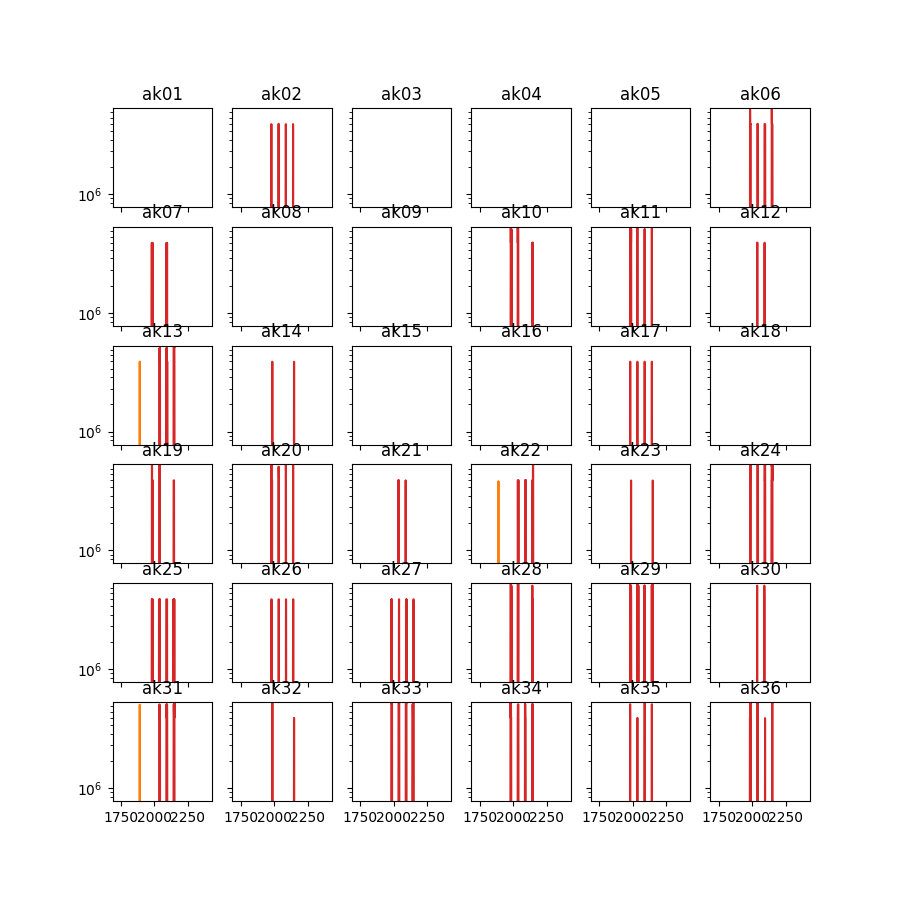

In [59]:

fig,ax = subplots(6,6, sharex=True, sharey=True)
fig.set_size_inches((9,9))
lines = []
for c in range(6):
    h = h5py.File(f'2022-09-07_024646_c{c}_XX.h5')
    b0 = h['B00']
    d = b0['amplitude/ampmatrices_auto']
    ax = ax.flatten()
    for b in range(36):
        #ax[b].imshow(d[b,:,:], aspect='auto', origin='lower')
        l, = ax[b].semilogy(d[b,:,:].max(axis=0))
        if (b == 0):
            lines.append(l)
        ax[b].set_title(f'ak{b+1:02d}')
        
#fig.figlegend(lines)

In [63]:
threshold = 1e6
npol = 2
nblock = 6
nant = 36
nbeam = 36
nchan = 2592
badcount = np.zeros((nbeam, npol, nant, nblock, nchan), dtype=np.int)
for ipol, pol in enumerate(['XX','YY']):
    for c in range(6):
        h = h5py.File(f'2022-09-07_024646_c{c}_{pol}.h5')
        for b in range(36):
            d = h[f'B{b:02d}/amplitude/ampmatrices_auto']
            badcount[b,ipol,:,c,:] = (d[:] > threshold).sum(axis=1)
        h.close()

In [64]:
badcount.shape # (beam, pol, ant, block, channel)

(36, 2, 36, 6, 2592)

<IPython.core.display.Javascript object>


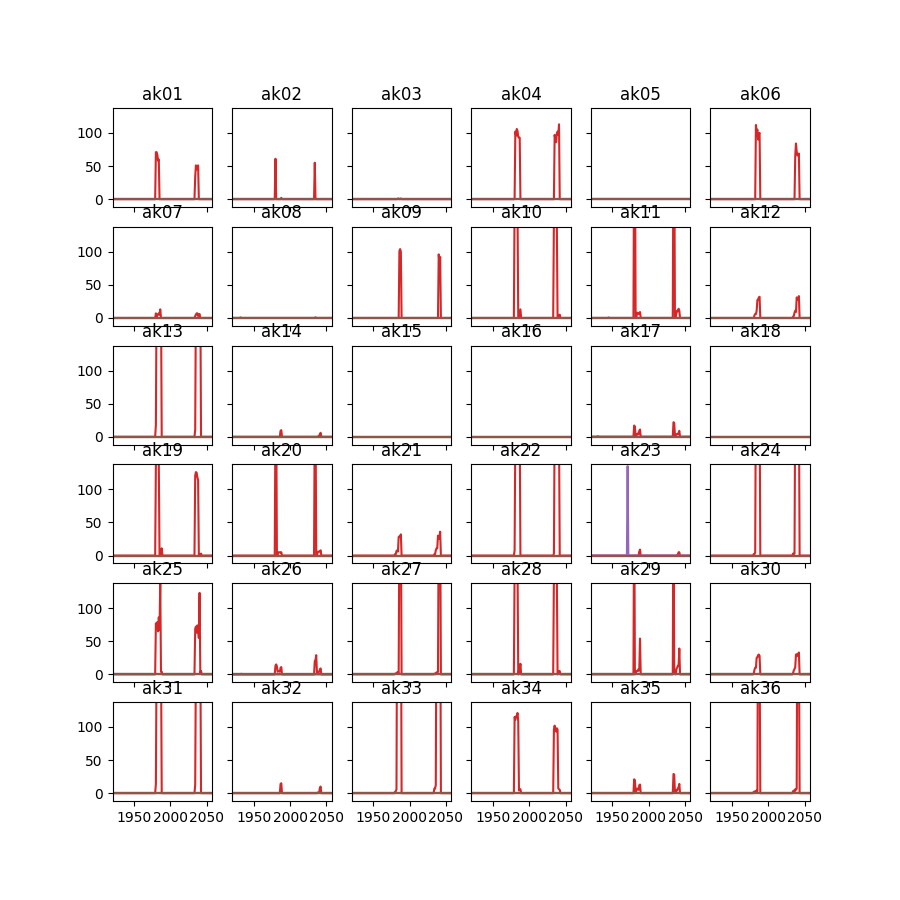

In [73]:
fig,ax = subplots(6,6, sharex=True, sharey=True)
fig.set_size_inches((9,9))
beam=0
pol=0
ax = ax.flatten()
for block in range(nblock):
    for ant in range(nant):
        l, = ax[ant].plot(badcount[:,pol,ant,block,:].sum(axis=0))        
        ax[ant].set_title(f'ak{ant+1:02d}')

<IPython.core.display.Javascript object>


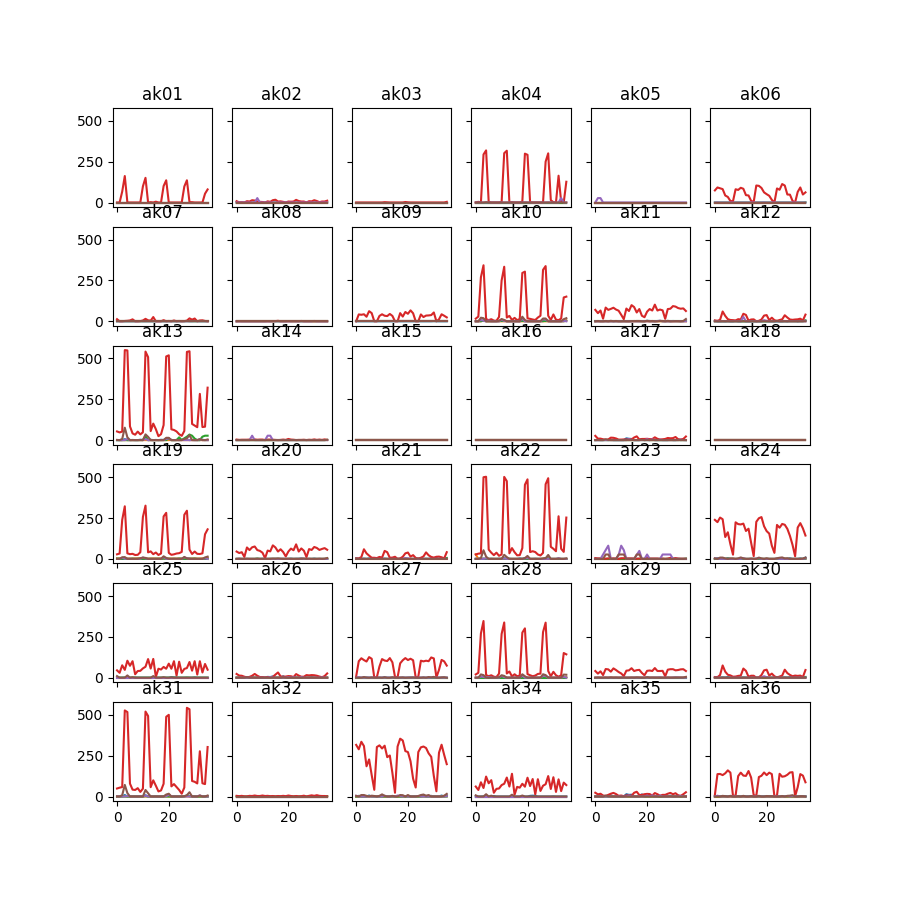

In [74]:
fig,ax = subplots(6,6, sharex=True, sharey=True)
fig.set_size_inches((9,9))
beam=0
pol=0
ax = ax.flatten()
for block in range(nblock):
    for ant in range(nant):
        l, = ax[ant].plot(badcount[:,pol,ant,block,:].sum(axis=1))        
        ax[ant].set_title(f'ak{ant+1:02d}')

In [75]:
badcount.shape # (beam, pol, ant, block, channel)

(36, 2, 36, 6, 2592)

<IPython.core.display.Javascript object>


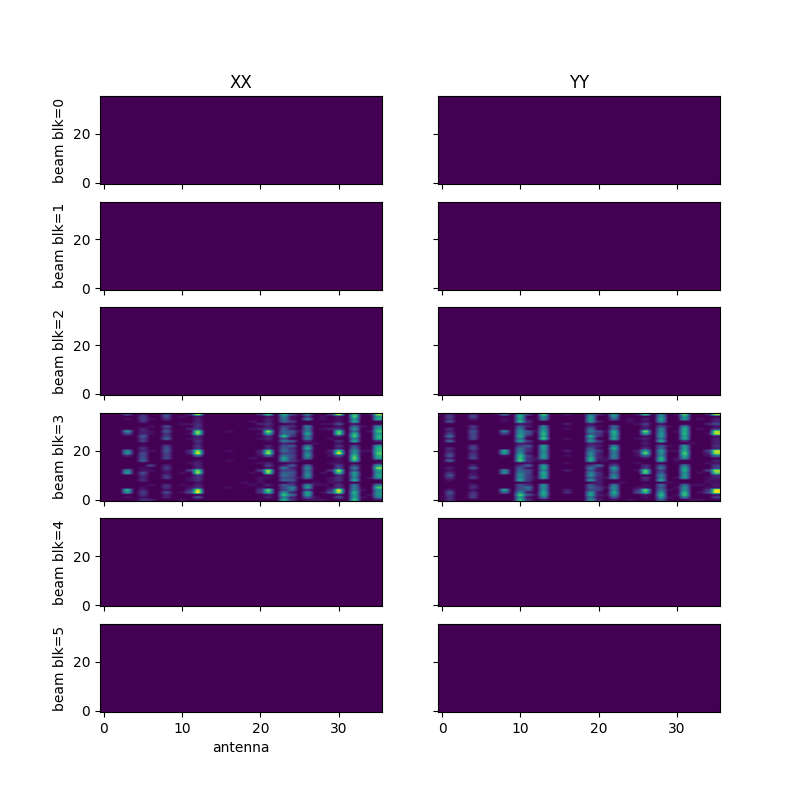

Text(0.5, 1.0, 'YY')

In [88]:
fig,ax = subplots(6,2, sharex=True, sharey=True)
fig.set_size_inches((9,7))
chanrange = slice(1986,1987) # bad one in my block 4
#chanrange=slice(None)
for block in range(nblock):
    ax[block,0].set_ylabel(f'beam blk={block}')
    for pol in range(npol):
        ax[block,pol].imshow(badcount[:,pol,:,block,chanrange].sum(axis=2),aspect='auto',origin='lower')
        
        
ax[-1,0].set_xlabel('antenna')
ax[0,0].set_title('XX')
ax[0,1].set_title('YY')

In [95]:
chanrange.

slice(1986, 1987, None)

<IPython.core.display.Javascript object>


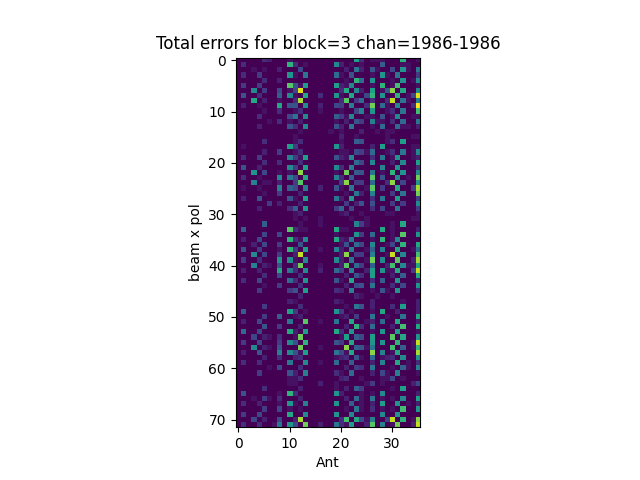

Text(0.5, 1.0, 'Total errors for block=3 chan=1986-1986')

In [97]:
figure()
block=3
badd = badcount[:,:,:,block,chanrange].sum(axis=3)
badd.shape # (beam, pol, ant)
imshow(badd.reshape(72,36))
ylabel('beam x pol')
xlabel('Ant')
title(f'Total errors for block={block} chan={chanrange.start}-{chanrange.stop-1}')



In [102]:
newshape = list(badcount.shape[:-1])
 # (6 fpgas, 4 coarse channels, 9 fine channels)
ncard = 12
nfpga = 6
ncoarse = 4
nfine = 9
newshape.extend([ncard, ncoarse, nfpga, nfine])
badcountf = badcount.copy().reshape(newshape)
badcountf.shape # (beam, pol, ant, block, card, coarse, fpga, fine)

(36, 2, 36, 6, 12, 4, 6, 9)

In [108]:
badcountfd = badcountf.reshape([nbeam, npol, nant, nblock*ncard, ncoarse, nfpga, nfine])
badcountfd.shape # (beam, pol, ant, block* card, coarse, fpga, fine)

(36, 2, 36, 72, 4, 6, 9)

<IPython.core.display.Javascript object>


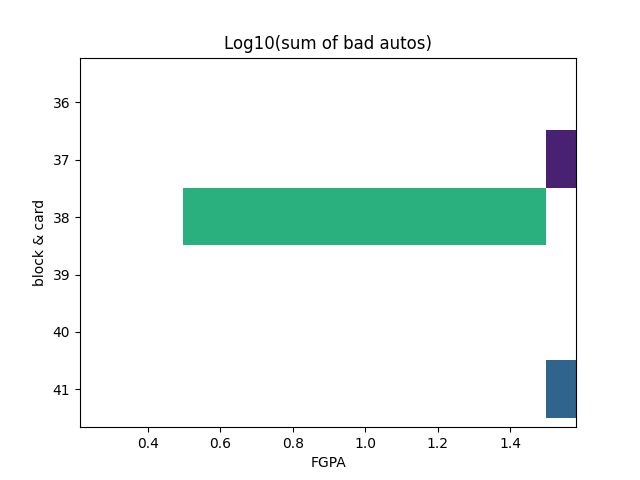

/data/craco/ban115/craco-python/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0.5, 1.0, 'Log10(sum of bad autos)')

In [114]:
figure()
imshow(np.log10(np.sum(badcountfd, axis=(0,1,2,4,6))), aspect='auto')
xlabel('FGPA')
ylabel('block & card')
title('Log10(sum of bad autos)')

In [115]:
badcountfd.shape

(36, 2, 36, 72, 4, 6, 9)

In [180]:
#badfpga = badcountfd[:,:,:,45,:,4,:] # The really bad one
badfpga = badcountfd[:,:,:,63,:,2,:] # The next bad one
badfpga.shape  # (beam, pol, ant,  coarse,  fine)

(36, 2, 36, 4, 9)

In [181]:
def plot_transpose(badfpga, transpose, label):
    fig,ax = subplots(1,2,sharex=True,sharey=True)
    d = np.transpose(badfpga, transpose)
    #d = badfpga
    fig.set_size_inches((9,5))
    ax[0].imshow(d[:,0,...].reshape(36, 36*4*9), aspect='auto')
    ax[1].imshow(d[:,1,...].reshape(36, 36*4*9), aspect='auto')
    ax[0].set_title('XX')
    ax[1].set_title('YY')
    ax[0].set_ylabel('beam')
    ax[0].set_xlabel(label)
    

<IPython.core.display.Javascript object>


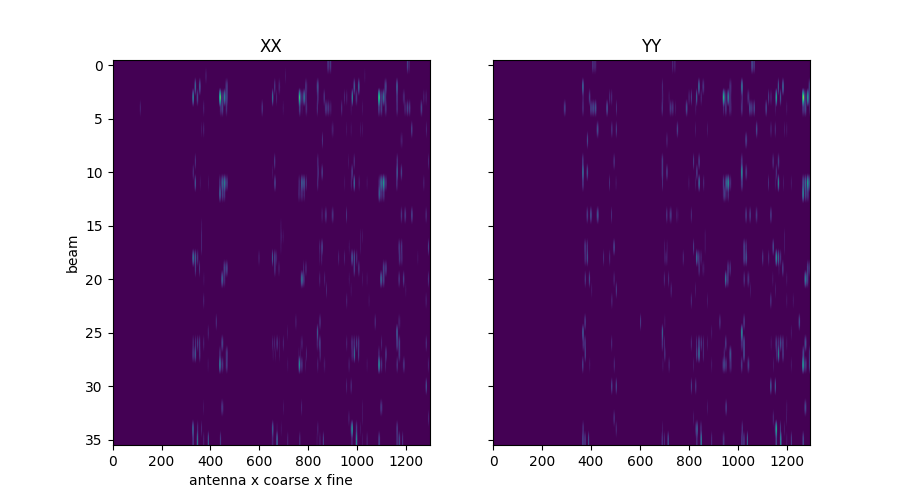

In [182]:
plot_transpose(badfpga, (0,1,2,3,4), 'antenna x coarse x fine')

<IPython.core.display.Javascript object>


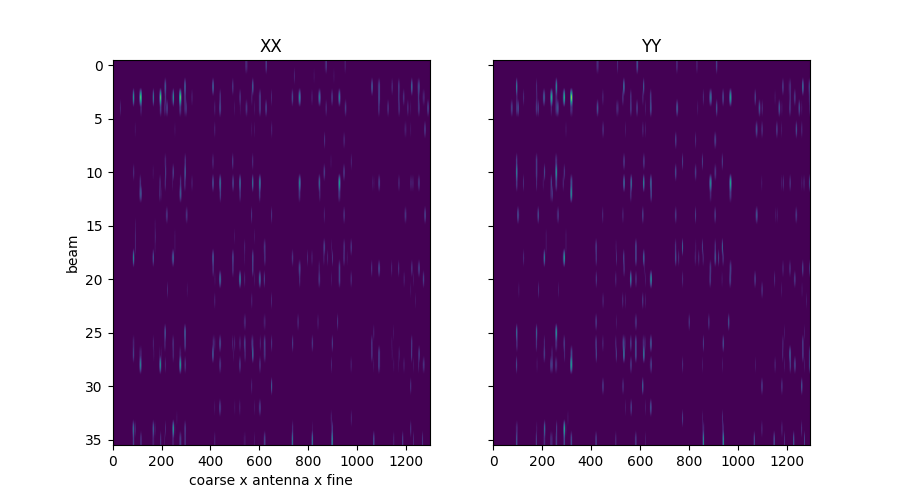

In [183]:
plot_transpose(badfpga, (0,1,3,2,4), 'coarse x antenna x fine')

In [184]:
badfpga.shape

(36, 2, 36, 4, 9)

<IPython.core.display.Javascript object>


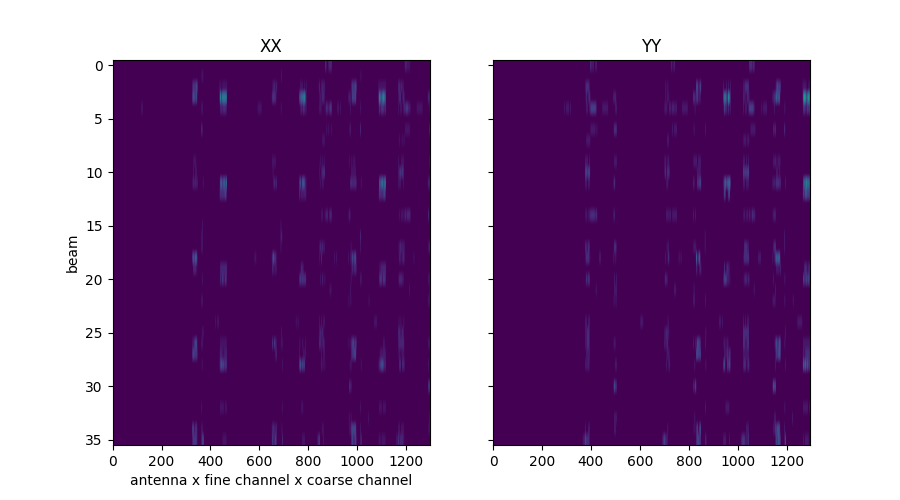

In [185]:
plot_transpose(badfpga, (0,1,2,4,3), 'antenna x fine channel x coarse channel')

In [186]:
badcountfd.shape # (beam, pol, ant, block* card, coarse, fpga, fine)

(36, 2, 36, 72, 4, 6, 9)

In [304]:
badcountfd_afc = np.transpose(badcountfd, [0,1,3,5,2,6,4])
badcountfd_afc.shape # beam, pol, block*card,fpga, ant, fine, coarse

(36, 2, 72, 6, 36, 9, 4)

<IPython.core.display.Javascript object>


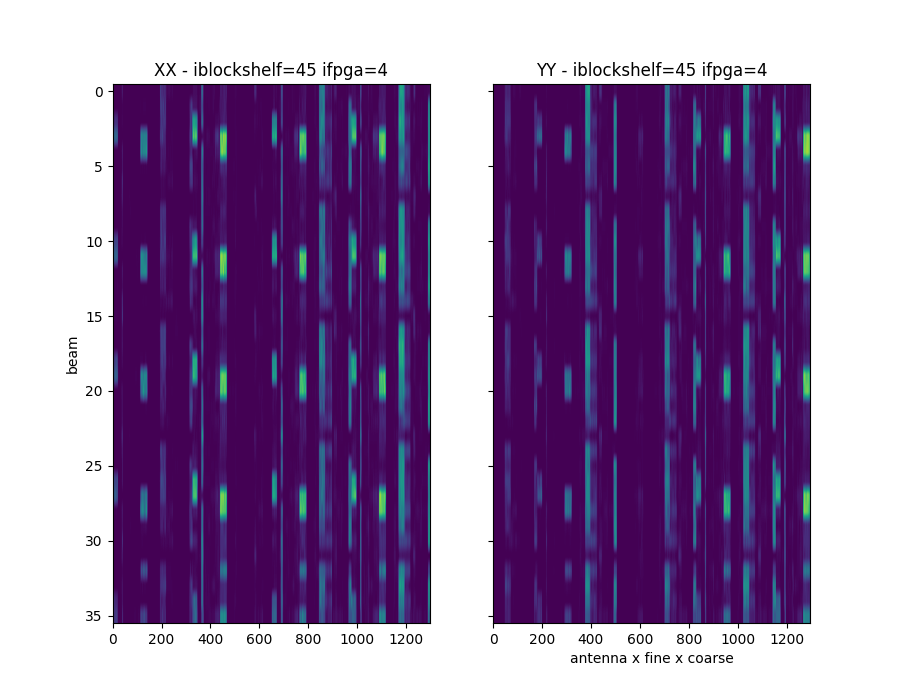

Text(0.5, 0, 'antenna x fine x coarse')

In [205]:
#badfpga = badcountfd[:,:,:,45,:,4,:] # The really bad one
#badfpga = badcountfd[:,:,:,63,:,2,:] # The next bad one
bad_devices = [(45,4),(63,2),(38,1)]
bad_devices = bad_devices[0:1]
def myplot(ax,d):
    ax.imshow(d.reshape(36,-1), aspect='auto')
    
fig,ax = subplots(len(bad_devices),2,sharex=True,sharey=True, squeeze=False)
fig.set_size_inches((9,7))
    
for idev, (iblockshelf, ifpga) in enumerate(bad_devices):
    myplot(ax[idev,0], badcountfd_afc[:,0,iblockshelf,ifpga,...])
    myplot(ax[idev,1], badcountfd_afc[:,1,iblockshelf,ifpga,...])
    ax[idev,0].set_title(f'XX - iblockshelf={iblockshelf} ifpga={ifpga}')
    ax[idev,1].set_title(f'YY - iblockshelf={iblockshelf} ifpga={ifpga}')

ax[-1,0].set_ylabel('beam')
ax[-1,1].set_xlabel('antenna x fine x coarse')

In [206]:
badcountfd_afc.shape

(36, 2, 72, 6, 36, 9, 4)

In [208]:
torder = np.transpose(badcountfd_afc, (2,3,6,0,4,1,5))
torder.shape

(72, 6, 4, 36, 36, 2, 9)

In [210]:
torder = torder.reshape((72,6,4*36,36,2,9))
torder.shape

(72, 6, 144, 36, 2, 9)

<IPython.core.display.Javascript object>


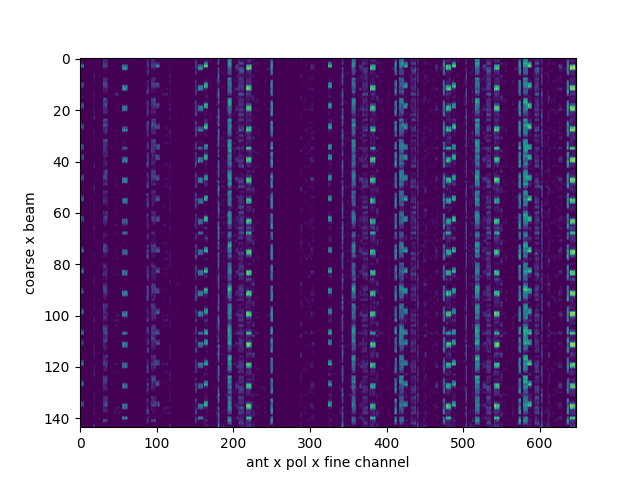

Text(0, 0.5, 'coarse x beam')

In [213]:
figure()
imshow(torder[45,4,:,...].reshape(144,-1),aspect='auto')
xlabel('ant x pol x fine channel')
ylabel('coarse x beam')

In [241]:
sigs = []

bout = 0
cout = 0
permute_idxs = []
for inc in range(4):
    for inb in range(32):
        idx = inb + inc*36
        permute_idxs.append(idx)
        sigs.append((inc, inb, cout, bout,idx))

        if bout == 35:
            cout = (cout + 1) % 4
            
        bout = (bout + 1) % 36       
        
        
for inc in range(4):
    for inb in range (32,36):
        idx = inb + inc*36

        permute_idxs.append(idx)
        sigs.append((inc, inb, cout,bout,idx))

        if bout == 35:
            cout = (cout + 1) % 4            
        bout = (bout + 1) % 36
        
#sigs

In [242]:
bad = torder[45,4,...].reshape(4*36,36,2,9)
bad.shape


(144, 36, 2, 9)

In [243]:
bad_torder = bad[permute_idxs,...]

<IPython.core.display.Javascript object>


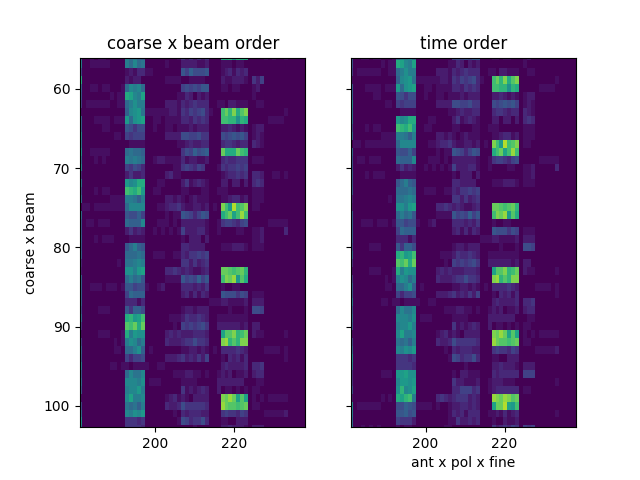

Text(0.5, 0, 'ant x pol x fine')

In [250]:
fig,ax = subplots(1,2,sharex=True, sharey=True)
ax[0].imshow(bad.reshape(144,-1), aspect='auto')
ax[1].imshow(bad_torder.reshape(144,-1),aspect='auto')
ax[0].set_title('coarse x beam order')
ax[1].set_title('time order')
ax[0].set_ylabel('coarse x beam')
ax[1].set_xlabel('ant x pol x fine')

<IPython.core.display.Javascript object>


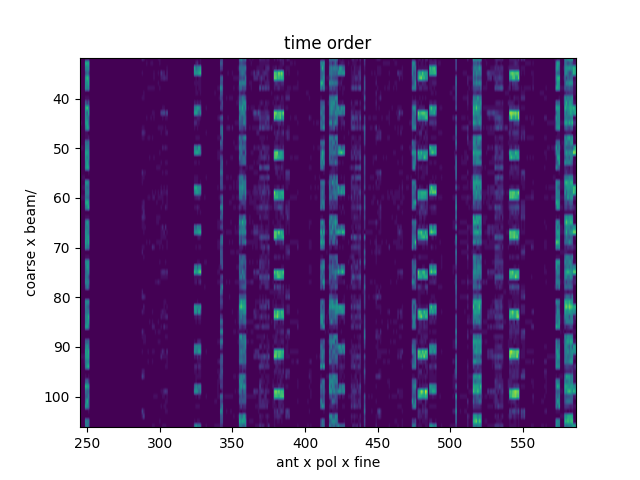

Text(0.5, 0, 'ant x pol x fine')

In [262]:
fig,ax = subplots(1,1,sharex=True, sharey=True)
ax = [ax]
ax[0].imshow(bad_torder.reshape(144,-1),aspect='auto')
ax[0].set_title('coarse x beam order')
ax[0].set_title('time order')
ax[0].set_ylabel('coarse x beam/')
ax[0].set_xlabel('ant x pol x fine')

<IPython.core.display.Javascript object>


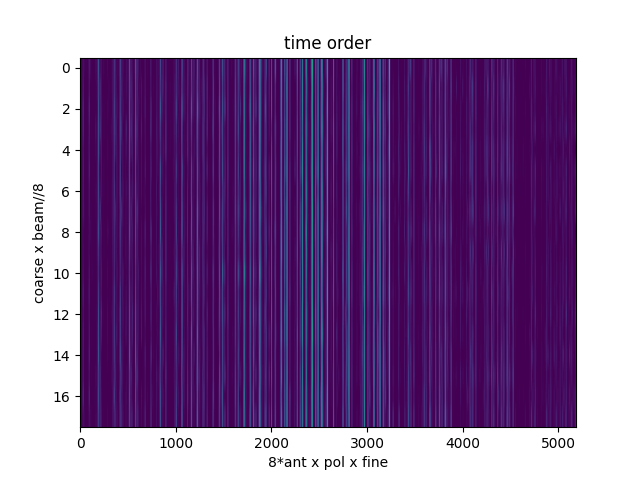

Text(0.5, 0, '8*ant x pol x fine')

In [261]:
fig,ax = subplots(1,1,sharex=True, sharey=True)
ax = [ax]
ax[0].imshow(bad_torder.reshape(144//8,-1),aspect='auto')
ax[0].set_title('coarse x beam order')
ax[0].set_title('time order')
ax[0].set_ylabel('coarse x beam//8')
ax[0].set_xlabel('8*ant x pol x fine')

In [263]:
bad_torder.shape

(144, 36, 2, 9)

<IPython.core.display.Javascript object>


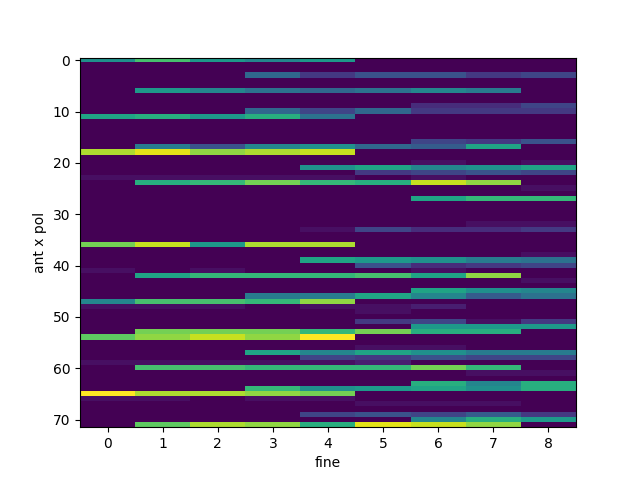

Text(0.5, 0, 'fine')

In [280]:
figure()
imshow(bad_torder[3,...].reshape(36*2,-1),aspect='auto')
ylabel('ant x pol')
xlabel('fine')

In [286]:
# pick out a bad one of the beamchans and reshape to nant*npol x nfine
badbeam = bad_torder[3,...].reshape(nant*npol,nfine)
badbeam.shape

(72, 9)

In [ ]:
figure()
imshow(badbeam[7::9,...],aspect='auto')
ylabel('ant x pol//9')
xlabel('fine')

When you look at the cell ordering diagram it's clear that when going through the corr cell products, when row==column you'll get autos for 9 fine freqs. All the cells are very close together (searated by a few clocks) so basically all autos from the top left corner (pos=0,0) come out withing a few clocks, then loop over different fine freqs, then a big gap while you go through 10 more cells, then all autos from pos=1,1 and so on. pos=0,0 for all the cells is Ant1A for cell 00, Ant5B for cell 1,1, Ant 10A for cell 2,2 etc. Basically if you stack all teh ants and pols together, it comes together in groups of 9.

In [302]:
# So let's re-order in groups of 9 - leave the fine channel axis alone.
badbeam_torder = np.transpose(badbeam.reshape((8,9,nfine)), (1,0,2)).reshape(nant*npol,nfine)

<IPython.core.display.Javascript object>


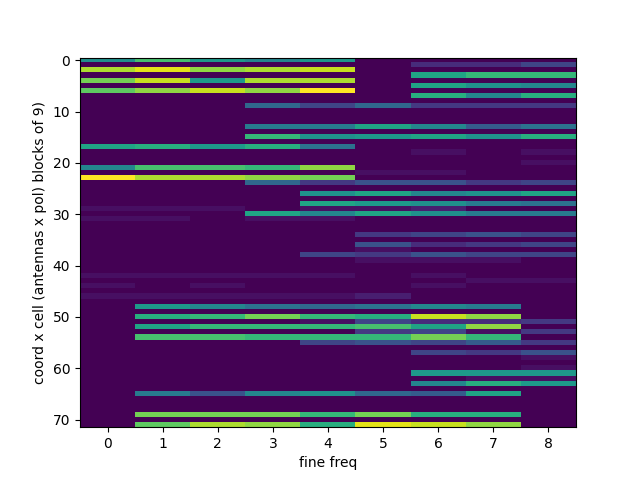

Text(0, 0.5, 'coord x cell (antennas x pol) blocks of 9)')

In [305]:
figure()
imshow(badbeam_torder, aspect='auto')
xlabel('fine freq')
ylabel('coord x cell (antennas x pol) blocks of 9)')